In [45]:
include("../utils/projToSmplx.jl");

In [290]:
using LinearAlgebra
using Plots
using Distributions
using Convex, SCS
using CSV
using DataFrames

# 4.2

In [478]:
n = 500
m = 50

alphas = [2.0^i for i = -12:7]
num_iters = 100
num_trials = 25

f(A, b, x) = maximum(A*x + b)
size(A)

(50, 500)

In [479]:
function pgd_update(A, b, x, alpha)
  fi = A*x + b
  gi = argmax(fi)
  g = A[gi, :]
  x -= alpha*g
  x = proj_simplex(x)
  return x
end

function md_update(A, b, x, alpha)
  fi = A*x + b
  gi = argmax(fi)
  g = A[gi, :]
  xi = x.*exp.(-alpha*g)
  x = xi ./ sum(xi)
  return x
end

pgd = Dict()
md = Dict()

function solve(A, b, update, f_star)
  best = Dict(
    "fbs"=>[Inf],
    "alpha"=>1
  )
  for alpha in alphas
    x = ones(n)
    fs = []
    fbs = []
    # println("alpha = $(alpha)")
    for i = 1:num_iters
      x = update(A, b, x, alpha)
      push!(fs, f(A, b, x))
      push!(fbs, minimum(fs))
    end
    if fbs[end] < best["fbs"][end]
      best["fbs"] = fbs
      best["alpha"] = alpha
    end
  end
  best["gaps"] = best["fbs"] .- f_star
  return best
end

pgd = Dict()
md = Dict()


for t = 1:num_trials
  A = rand(MvNormal(zeros(n), I), m)'
  b = rand(Normal(), m)

  x = Variable(n) 
  problem = minimize(f(A, b, x), [x >= 0, x⋅ones(n) == 1])
  solve!(problem, SCS.Optimizer; silent_solver = true)
  f_star = problem.optval
  println("t = $(t), f_star = $(f_star)")

  pgd[t] = solve(A, b, pgd_update, f_star)
  md[t] = solve(A, b, md_update, f_star)
end


t = 1, f_star = 0.852524038204872
t = 2, f_star = 0.1928178488020522
t = 3, f_star = 1.0465722754287765
t = 4, f_star = 0.9821070170694478
t = 5, f_star = 0.6738852207448561
t = 6, f_star = 0.5398309395745085
t = 7, f_star = 1.0310931548746771
t = 8, f_star = 0.7334669554347543
t = 9, f_star = 0.7753896560506596
t = 10, f_star = 1.7259004633523476
t = 11, f_star = 0.5981156966601784
t = 12, f_star = 0.8524082236862834
t = 13, f_star = 0.5743200819049914
t = 14, f_star = 0.5942578553123924
t = 15, f_star = 0.501993759445382
t = 16, f_star = 0.8605507204458542
t = 17, f_star = 0.9410094371328211
t = 18, f_star = 0.9897385916721287
t = 19, f_star = 0.37730484004106557
t = 20, f_star = 0.7914739902000903
t = 21, f_star = 0.8096364489322793
t = 22, f_star = 0.6945581447287749
t = 23, f_star = 1.303792377975964
t = 24, f_star = 1.0680764250521295
t = 25, f_star = 0.8913081772756131


In [480]:
average_md_gaps = mean(hcat([best["gaps"] for (k,best) in md]...), dims=2)
average_pgd_gaps = mean(hcat([best["gaps"] for (k,best) in pgd]...), dims=2)

100×1 Matrix{Float64}:
 1.447673547688695
 1.0813731722143285
 0.9583281217502297
 0.847002237330293
 0.7773932693471376
 0.70019984962725
 0.6719173418709332
 0.636517050783162
 0.6127293334449978
 0.5762364765679149
 0.5585443554530201
 0.5278795574002746
 0.5136158034262128
 ⋮
 0.21422847924429056
 0.21346840250091476
 0.21075486364226376
 0.21024263289159945
 0.20954857056831366
 0.2082660420415902
 0.2075480738459397
 0.20638529779358422
 0.20529085432318803
 0.20385290056801922
 0.20264614532384811
 0.2020089942595015

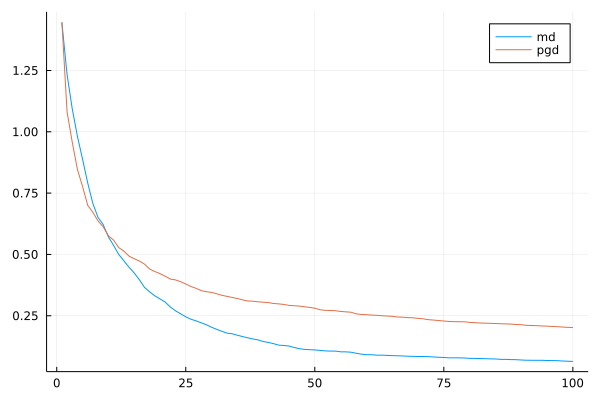

In [481]:
p = plot()
plot!(average_md_gaps, label="md")
plot!(average_pgd_gaps, label="pgd")

Mirror descent gives better performance.

# 4.3

In [452]:
read(path) = Matrix(CSV.read(path, header=false, DataFrame))
A = read("Amatrix.csv")
b = read("bvector.csv")

println(size(A), size(b))
m, n = size(A)

(100, 10)(100, 1)


(100, 10)

In [453]:
x = Variable(n)
r = Variable()

problem = maximize(r, [a⋅x + r*norm(a) <= bi for (a,bi) = zip(eachrow(A), b)])
solve!(problem, SCS.Optimizer; silent_solver = true)
println(problem.status)
println(problem.optval)
println(x.value)
xb = x.value

OPTIMAL
0.21923451669185473
[-0.03600167443075779; 0.021395695845102446; 0.030668044600291728; -0.10659469344900396; -0.008530160059221026; 0.0001930917064919193; 0.01455210755075613; -0.024291423500821543; -0.015249062222055342; 0.03914917245272635;;]


10×1 Matrix{Float64}:
 -0.03600167443075779
  0.021395695845102446
  0.030668044600291728
 -0.10659469344900396
 -0.008530160059221026
  0.0001930917064919193
  0.01455210755075613
 -0.024291423500821543
 -0.015249062222055342
  0.03914917245272635

In [454]:
d = Variable(n)
B = Variable(n, n)
problem = maximize(logdet(B), [[norm(B*a) + a⋅d <= bi for (a,bi) in zip(eachrow(A), b)]..., B ⪰ 0])
solve!(problem, SCS.Optimizer; silent_solver = true)
println(problem.status, problem.optval, d.value)
xe = d.value


OPTIMAL-13.378248815843227[0.02764846603250841; 0.04322510364598906; -0.03442505653778901; -0.006654747236129646; -0.026624214093488537; 0.015254891310857274; 0.00880197362261148; -0.004429562044468752; -0.0324929722233126; -0.0012396157413082595;;]


10×1 Matrix{Float64}:
  0.02764846603250841
  0.04322510364598906
 -0.03442505653778901
 -0.006654747236129646
 -0.026624214093488537
  0.015254891310857274
  0.00880197362261148
 -0.004429562044468752
 -0.0324929722233126
 -0.0012396157413082595

In [455]:
println(xe)
println(xb)

[0.02764846603250841; 0.04322510364598906; -0.03442505653778901; -0.006654747236129646; -0.026624214093488537; 0.015254891310857274; 0.00880197362261148; -0.004429562044468752; -0.0324929722233126; -0.0012396157413082595;;]
[-0.03600167443075779; 0.021395695845102446; 0.030668044600291728; -0.10659469344900396; -0.008530160059221026; 0.0001930917064919193; 0.01455210755075613; -0.024291423500821543; -0.015249062222055342; 0.03914917245272635;;]


In [463]:
d = Int(1e6)
xs = rand(Uniform(-0.5, 0.5), n, d)

Mc = 0
Me = 0
Mb = 0

for x in eachcol(xs)
  if all(A*x .<= b)
    Mc += 1
    Mb += sum(g*(x.-xb)) >= 0
    Me += sum(g*(x.-xe)) >= 0
  end
end

Re = Me/Mc
Rb = Mb/Mc
Re,Rb

(0.49286498353457736, 0.5477497255762898)

# 4.4

In [482]:
n = 20
m = 100
A = randn(m,n)
b = randn(m)

x = ones(n)

num_iters = 40
eps = 1e-6

f₁(x) = maximum(a⋅x + bi for (a,bi) in zip(eachrow(A), b))
g₁(x) = A[argmax([a⋅x + bi for (a,bi) in zip(eachrow(A), b)]), :]
f̂(xs, fs, gs, x) = maximum(fs[i] + gs[i]⋅(x-xs[i]) for i = 1:length(xs))
function L(xs, fs, gs)
  x = Variable(n)
  problem = minimize(f̂(xs, fs, gs, x), vcat([[x[i] <= 1, x[i] >= -1] for i = 1:n]...))
  solve!(problem, SCS.Optimizer; silent_solver = true)
  # println(problem.status, problem.optval, x.value)
  return (problem.optval, x.value)
end
U(fs) = minimum(fs)

xs = []
gs = []
fs = []
Us = []
Ls = []

println(f₁(x))
println(g₁(x))  
push!(xs, x)
push!(gs, g₁(x))
push!(fs, f₁(x))
println(f̂(xs, fs, gs, x))
println(L(xs, fs, gs))
println(U(fs))

11.918771302188368
[1.0680768681828265, 0.9265931539562218, -1.008695716231606, -0.946442233997854, 1.2427201231550904, 2.618880112333096, 1.6510577856259214, 0.47486708324186977, 0.2432708587917683, -0.033927881498232816, 1.9439012309287516, -0.8660574977990254, 2.510389757998453, -0.6507748823693614, 0.7263087060892423, -0.19887037304907773, 0.4399653986612277, 0.7095089756878005, 1.4357290514140086, -0.18921102351840546]
11.918771302188368
(-20.063784012892615, [-1.0000000052784594; -1.0000026155492365; 1.0000007169173037; 1.000002130815259; -0.9999980198465851; -1.0000008227452295; -0.9999941767065172; -1.000012154877928; -1.0000117748324548; 0.9999916546794608; -0.9999944418015743; 1.0000040938737051; -0.9999997672279574; 1.0000093510691535; -1.000007506560513; 1.0000123493964161; -1.0000116516491862; -1.0000079168059481; -0.9999959818078643; 1.0000125572714011;;])
11.918771302188368


In [483]:
for k = 1:num_iters
  gx = g₁(x)
  fx = f₁(x)
  push!(gs, gx)
  push!(fs, fx)
  push!(xs, x)

  Lk, x_ = L(xs, fs, gs)
  Uk = U(fs)
  x = x_

  push!(Ls, Lk)
  push!(Us, Uk)

  if abs(Uk-Lk) <= eps
    break
  end
  # break
end

1.0609085858170613


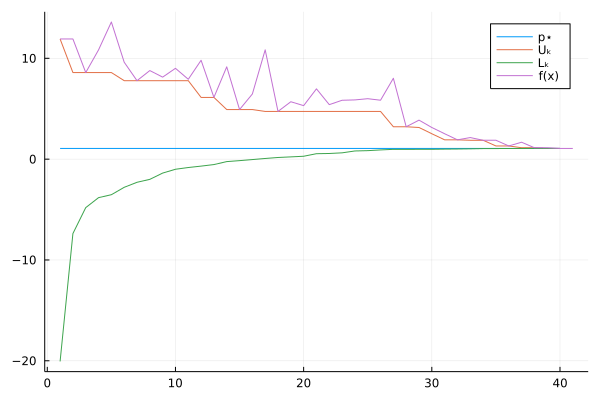

In [484]:
x = Variable(n)
problem = minimize(f₁(x), vcat([[x[i] <= 1, x[i] >= -1] for i = 1:n]...))
solve!(problem, SCS.Optimizer; silent_solver = true)
p_star = problem.optval
println(p_star)

p = plot()
plot!(1:length(Us), repeat([p_star], length(Us)), label="p⋆")
plot!(1:length(Us), Us, label="Uₖ")
plot!(1:length(Ls), Ls, label="Lₖ")
plot!(1:length(fs), fs, label="f(x)")

In [485]:
c = rand(Uniform(-1, 1), n)
f₂(x) = norm(x-c)
g₂(x) = (x-c)./norm(x-c)

xs = []
gs = []
fs = []
Us = []
Ls = []

x = ones(n)

for k = 1:300
  gx = g₂(x)
  fx = f₂(x)
  push!(gs, gx)
  push!(fs, fx)
  push!(xs, x)

  Lk, x_ = L(xs, fs, gs)
  Uk = U(fs)
  x = x_

  push!(Ls, Lk)
  push!(Us, Uk)

  if abs(Uk-Lk) <= eps
    break
  end
  # break
end

6.04679381130455e-6


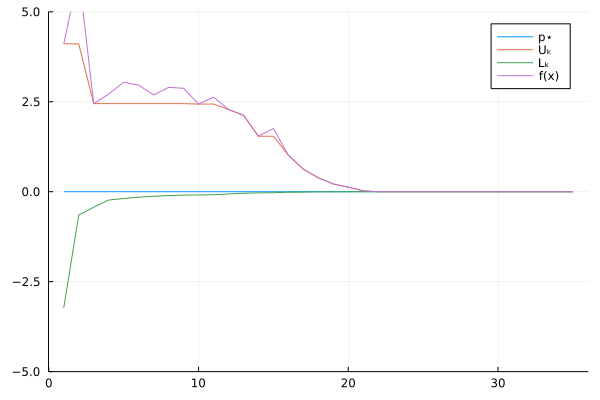

In [486]:
x = Variable(n)
problem = minimize(f₂(x), vcat([[x[i] <= 1, x[i] >= -1] for i = 1:n]...))
solve!(problem, SCS.Optimizer; silent_solver = true)
p_star = problem.optval
println(p_star)


p = plot()
plot!(1:length(Us), repeat([p_star], length(Us)), label="p⋆")
plot!(1:length(Us), Us, label="Uₖ")
plot!(1:length(Ls), Ls, label="Lₖ")
plot!(1:length(fs), fs, label="f(x)")
ylims!((-5, 5))